# Notebook 02: EDA - AI in Hiring Attitudes

**Exploratory Data Analysis of the AI in Hiring Block**

This notebook covers:
1. Weighted distributions of all hiring-related variables
2. Missingness analysis
3. Subgroup splits by demographics
4. Bivariate associations with the primary outcome
5. Visualizations for key findings

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [2]:
# Load data and metadata from notebook 01
df = pd.read_pickle('../data_full.pkl')
df_analysis = pd.read_pickle('../data_analysis_ready.pkl')

with open('../metadata.pkl', 'rb') as f:
    meta = pickle.load(f)

# Extract key references
WEIGHT_VAR = meta['weight_var']
HIRING_VARS = meta['hiring_vars']
DEMO_VARS = meta['demo_vars']
column_labels = meta['column_labels']
value_labels = meta['value_labels']

print(f"Loaded {len(df):,} respondents")
print(f"Hiring variables: {HIRING_VARS}")

Loaded 11,004 respondents
Hiring variables: ['AIWRKH1_W119', 'AIWRKH2_a_W119', 'AIWRKH2_b_W119', 'AIWRKH3_a_W119', 'AIWRKH3_b_W119', 'AIWRKH3_c_W119', 'AIWRKH3_d_W119', 'AIWRKH4_W119', 'HIREBIAS1_W119', 'HIREBIAS2_W119']


In [3]:
# Utility functions for weighted analysis

def weighted_freq_table(df, var, weight_var='WEIGHT_W119', exclude_missing=True):
    """Calculate weighted frequency table with labels."""
    # Get valid responses
    if exclude_missing:
        valid_mask = df[var].notna() & (df[var] != 99)
    else:
        valid_mask = df[var].notna()
    
    valid_df = df[valid_mask].copy()
    val_labs = value_labels.get(var, {})
    
    # Calculate weighted frequencies
    total_weight = valid_df[weight_var].sum()
    
    results = []
    for value in sorted(valid_df[var].unique()):
        mask = valid_df[var] == value
        weight_sum = valid_df.loc[mask, weight_var].sum()
        pct = (weight_sum / total_weight) * 100
        label = val_labs.get(value, f"Code {value}")
        results.append({
            'code': value,
            'label': label,
            'n_unweighted': mask.sum(),
            'weighted_pct': round(pct, 1)
        })
    
    return pd.DataFrame(results)


def weighted_crosstab(df, row_var, col_var, weight_var='WEIGHT_W119'):
    """Calculate weighted crosstab percentages."""
    # Filter to valid values
    mask = df[row_var].notna() & df[col_var].notna() & (df[row_var] != 99) & (df[col_var] != 99)
    valid_df = df[mask].copy()
    
    # Get labels
    row_labs = value_labels.get(row_var, {})
    col_labs = value_labels.get(col_var, {})
    
    results = []
    for col_val in sorted(valid_df[col_var].unique()):
        col_mask = valid_df[col_var] == col_val
        col_total = valid_df.loc[col_mask, weight_var].sum()
        
        for row_val in sorted(valid_df[row_var].unique()):
            cell_mask = col_mask & (valid_df[row_var] == row_val)
            cell_weight = valid_df.loc[cell_mask, weight_var].sum()
            pct = (cell_weight / col_total) * 100 if col_total > 0 else 0
            
            results.append({
                'row_var': row_var,
                'row_code': row_val,
                'row_label': row_labs.get(row_val, str(row_val)),
                'col_var': col_var,
                'col_code': col_val,
                'col_label': col_labs.get(col_val, str(col_val)),
                'weighted_pct': round(pct, 1),
                'n_unweighted': cell_mask.sum()
            })
    
    return pd.DataFrame(results)

## 1. Weighted Distributions of AI Hiring Variables

In [4]:
# Display weighted frequencies for all hiring variables
print("WEIGHTED DISTRIBUTIONS - AI HIRING BLOCK")
print("="*70)

for var in HIRING_VARS:
    if var in df.columns:
        var_label = column_labels.get(var, var)
        print(f"\n{var}")
        print(f"Q: {var_label}")
        print("-"*60)
        freq = weighted_freq_table(df, var)
        print(freq.to_string(index=False))
        print()

WEIGHTED DISTRIBUTIONS - AI HIRING BLOCK

AIWRKH1_W119
Q: AIWRKH1_W119. Thinking now about how AI can be used in hiring… How much have you heard or read about artificial intelligence (AI) being used by employers in the hiring process?
------------------------------------------------------------
 code          label  n_unweighted  weighted_pct
  1.0          A lot           817           7.0
  2.0       A little          3696          32.1
  3.0 Nothing at all          6454          60.9


AIWRKH2_a_W119
Q: AIWRKH2_a_W119. Would you favor or oppose employers’ use of artificial intelligence (AI) for…    Reviewing job applications
------------------------------------------------------------
 code    label  n_unweighted  weighted_pct
  1.0    Favor          3400          28.0
  2.0   Oppose          4303          41.6
  9.0 Not sure          3264          30.4


AIWRKH2_b_W119
Q: AIWRKH2_b_W119. Would you favor or oppose employers’ use of artificial intelligence (AI) for…    Making a final

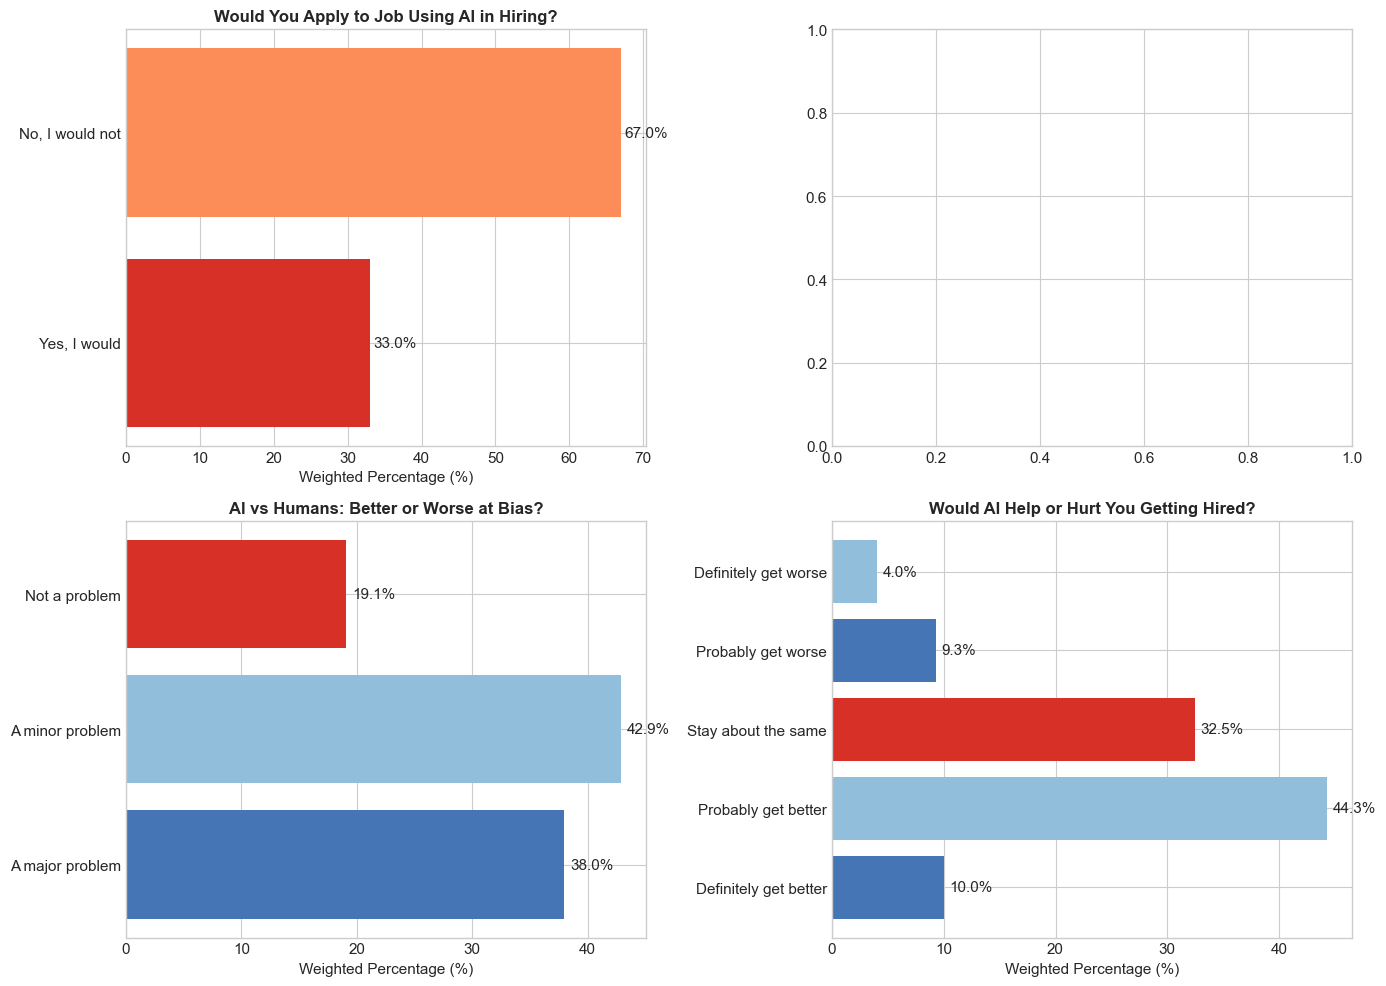

In [5]:
# Visualize key hiring attitudes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# AIWRKH4 - Would apply to job using AI
var = 'AIWRKH4_W119'
if var in df.columns:
    freq = weighted_freq_table(df, var)
    colors = ['#d73027', '#fc8d59', '#91bfdb', '#4575b4']  # Red to blue
    axes[0, 0].barh(freq['label'], freq['weighted_pct'], color=colors[:len(freq)])
    axes[0, 0].set_xlabel('Weighted Percentage (%)')
    axes[0, 0].set_title('Would You Apply to Job Using AI in Hiring?', fontsize=12, fontweight='bold')
    for i, v in enumerate(freq['weighted_pct']):
        axes[0, 0].text(v + 0.5, i, f'{v:.1f}%', va='center')

# AIWRKH2 - Opinion on AI reviewing applications
var = 'AIWRKH2_W119'
if var in df.columns:
    freq = weighted_freq_table(df, var)
    colors = ['#d73027', '#fc8d59', '#fee090', '#91bfdb', '#4575b4']
    axes[0, 1].barh(freq['label'], freq['weighted_pct'], color=colors[:len(freq)])
    axes[0, 1].set_xlabel('Weighted Percentage (%)')
    axes[0, 1].set_title('Opinion: AI Reviewing Job Applications', fontsize=12, fontweight='bold')
    for i, v in enumerate(freq['weighted_pct']):
        axes[0, 1].text(v + 0.5, i, f'{v:.1f}%', va='center')

# HIREBIAS1 - AI better/worse at bias
var = 'HIREBIAS1_W119'
if var in df.columns:
    freq = weighted_freq_table(df, var)
    colors = ['#4575b4', '#91bfdb', '#d73027']
    axes[1, 0].barh(freq['label'], freq['weighted_pct'], color=colors[:len(freq)])
    axes[1, 0].set_xlabel('Weighted Percentage (%)')
    axes[1, 0].set_title('AI vs Humans: Better or Worse at Bias?', fontsize=12, fontweight='bold')
    for i, v in enumerate(freq['weighted_pct']):
        axes[1, 0].text(v + 0.5, i, f'{v:.1f}%', va='center')

# HIREBIAS2 - AI help/hurt getting hired
var = 'HIREBIAS2_W119'
if var in df.columns:
    freq = weighted_freq_table(df, var)
    colors = ['#4575b4', '#91bfdb', '#d73027']
    axes[1, 1].barh(freq['label'], freq['weighted_pct'], color=colors[:len(freq)])
    axes[1, 1].set_xlabel('Weighted Percentage (%)')
    axes[1, 1].set_title('Would AI Help or Hurt You Getting Hired?', fontsize=12, fontweight='bold')
    for i, v in enumerate(freq['weighted_pct']):
        axes[1, 1].text(v + 0.5, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.savefig('../reports/hiring_attitudes_overview.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Missingness Analysis

MISSINGNESS ANALYSIS - AI HIRING BLOCK
      variable  n_valid  n_missing_na  n_refused_dk  pct_valid  pct_missing
  AIWRKH1_W119    10967             0            37       99.7          0.3
AIWRKH2_a_W119    10967             0            37       99.7          0.3
AIWRKH2_b_W119    10975             0            29       99.7          0.3
AIWRKH3_a_W119    10942             0            62       99.4          0.6
AIWRKH3_b_W119    10943             0            61       99.4          0.6
AIWRKH3_c_W119    10942             0            62       99.4          0.6
AIWRKH3_d_W119    10939             0            65       99.4          0.6
  AIWRKH4_W119    10771             0           233       97.9          2.1
HIREBIAS1_W119    10787             0           217       98.0          2.0
HIREBIAS2_W119     8812          2093            99       80.1         19.9


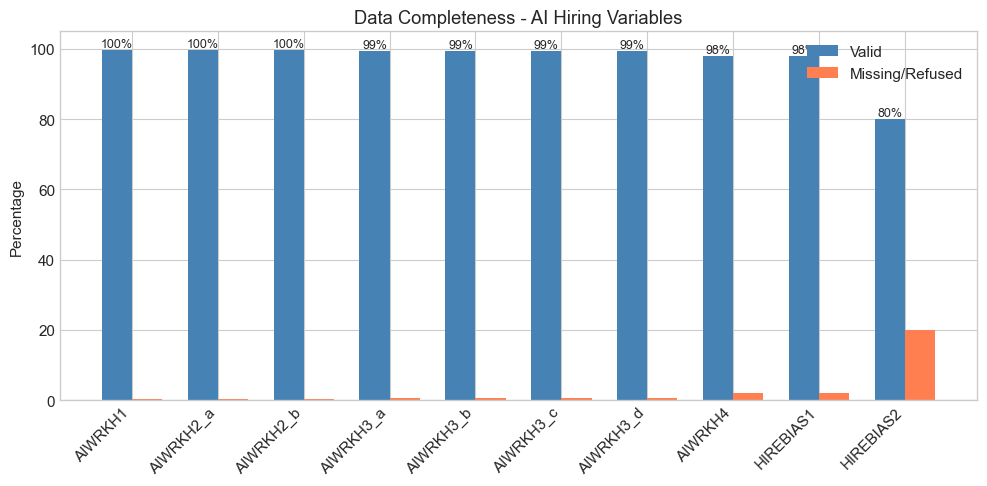

In [6]:
# Analyze missingness in hiring block
print("MISSINGNESS ANALYSIS - AI HIRING BLOCK")
print("="*70)

missing_data = []
for var in HIRING_VARS:
    if var in df.columns:
        n_total = len(df)
        n_na = df[var].isna().sum()
        n_99 = (df[var] == 99).sum()  # Refused/Don't know
        n_valid = n_total - n_na - n_99
        
        missing_data.append({
            'variable': var,
            'n_valid': n_valid,
            'n_missing_na': n_na,
            'n_refused_dk': n_99,
            'pct_valid': round(n_valid/n_total*100, 1),
            'pct_missing': round((n_na + n_99)/n_total*100, 1)
        })

missing_df = pd.DataFrame(missing_data)
print(missing_df.to_string(index=False))

# Visualize missingness
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(missing_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], missing_df['pct_valid'], width, label='Valid', color='steelblue')
bars2 = ax.bar([i + width/2 for i in x], missing_df['pct_missing'], width, label='Missing/Refused', color='coral')

ax.set_ylabel('Percentage')
ax.set_title('Data Completeness - AI Hiring Variables')
ax.set_xticks(x)
ax.set_xticklabels([v.replace('_W119', '') for v in missing_df['variable']], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 105)

for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../reports/missingness_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Subgroup Analysis by Demographics

Examine how willingness to apply varies by key demographics.

In [8]:
# Create binary outcome for analysis (1=Yes, 2=No in original coding)
df['AIWRKH4_BINARY'] = df['AIWRKH4_W119'].map({1.0: 1, 2.0: 0})

def weighted_mean_by_group(df, outcome_var, group_var, weight_var='WEIGHT_W119'):
    """Calculate weighted proportion of positive outcome by group."""
    # Filter to valid cases
    mask = df[outcome_var].notna() & df[group_var].notna()
    valid_df = df[mask].copy()
    
    group_labs = value_labels.get(group_var, {})
    
    results = []
    for group_val in sorted(valid_df[group_var].unique()):
        group_mask = valid_df[group_var] == group_val
        group_data = valid_df[group_mask]
        
        # Weighted proportion
        weighted_sum = (group_data[outcome_var] * group_data[weight_var]).sum()
        total_weight = group_data[weight_var].sum()
        weighted_pct = (weighted_sum / total_weight) * 100 if total_weight > 0 else 0
        
        results.append({
            'group_code': group_val,
            'group_label': group_labs.get(group_val, str(group_val)),
            'n_unweighted': len(group_data),
            'pct_would_apply': round(weighted_pct, 1)
        })
    
    return pd.DataFrame(results)

# Analyze by age
print("WILLINGNESS TO APPLY BY AGE GROUP")
print("="*60)
age_results = weighted_mean_by_group(df, 'AIWRKH4_BINARY', 'F_AGECAT')
print(age_results.to_string(index=False))

WILLINGNESS TO APPLY BY AGE GROUP
 group_code group_label  n_unweighted  pct_would_apply
        1.0       18-29           916             38.1
        2.0       30-49          3477             35.7
        3.0       50-64          3107             28.9
        4.0         65+          3237             29.1
       99.0     Refused            34             26.0


In [9]:
# Analyze by multiple demographics (using correct variable names)
demo_results = {}

for demo_var in ['F_AGECAT', 'F_GENDER', 'F_EDUCCAT2', 'F_RACETHNMOD']:
    if demo_var in df.columns:
        demo_results[demo_var] = weighted_mean_by_group(df, 'AIWRKH4_BINARY', demo_var)
        print(f"\nWILLINGNESS TO APPLY BY {demo_var}")
        print("-"*60)
        print(demo_results[demo_var].to_string(index=False))


WILLINGNESS TO APPLY BY F_AGECAT
------------------------------------------------------------
 group_code group_label  n_unweighted  pct_would_apply
        1.0       18-29           916             38.1
        2.0       30-49          3477             35.7
        3.0       50-64          3107             28.9
        4.0         65+          3237             29.1
       99.0     Refused            34             26.0

WILLINGNESS TO APPLY BY F_GENDER
------------------------------------------------------------
 group_code       group_label  n_unweighted  pct_would_apply
        1.0             A man          4796             37.6
        2.0           A woman          5855             28.6
        3.0 In some other way            91             40.0
       99.0           Refused            29             20.3

WILLINGNESS TO APPLY BY F_EDUCCAT2
------------------------------------------------------------
 group_code                     group_label  n_unweighted  pct_would_apply
   

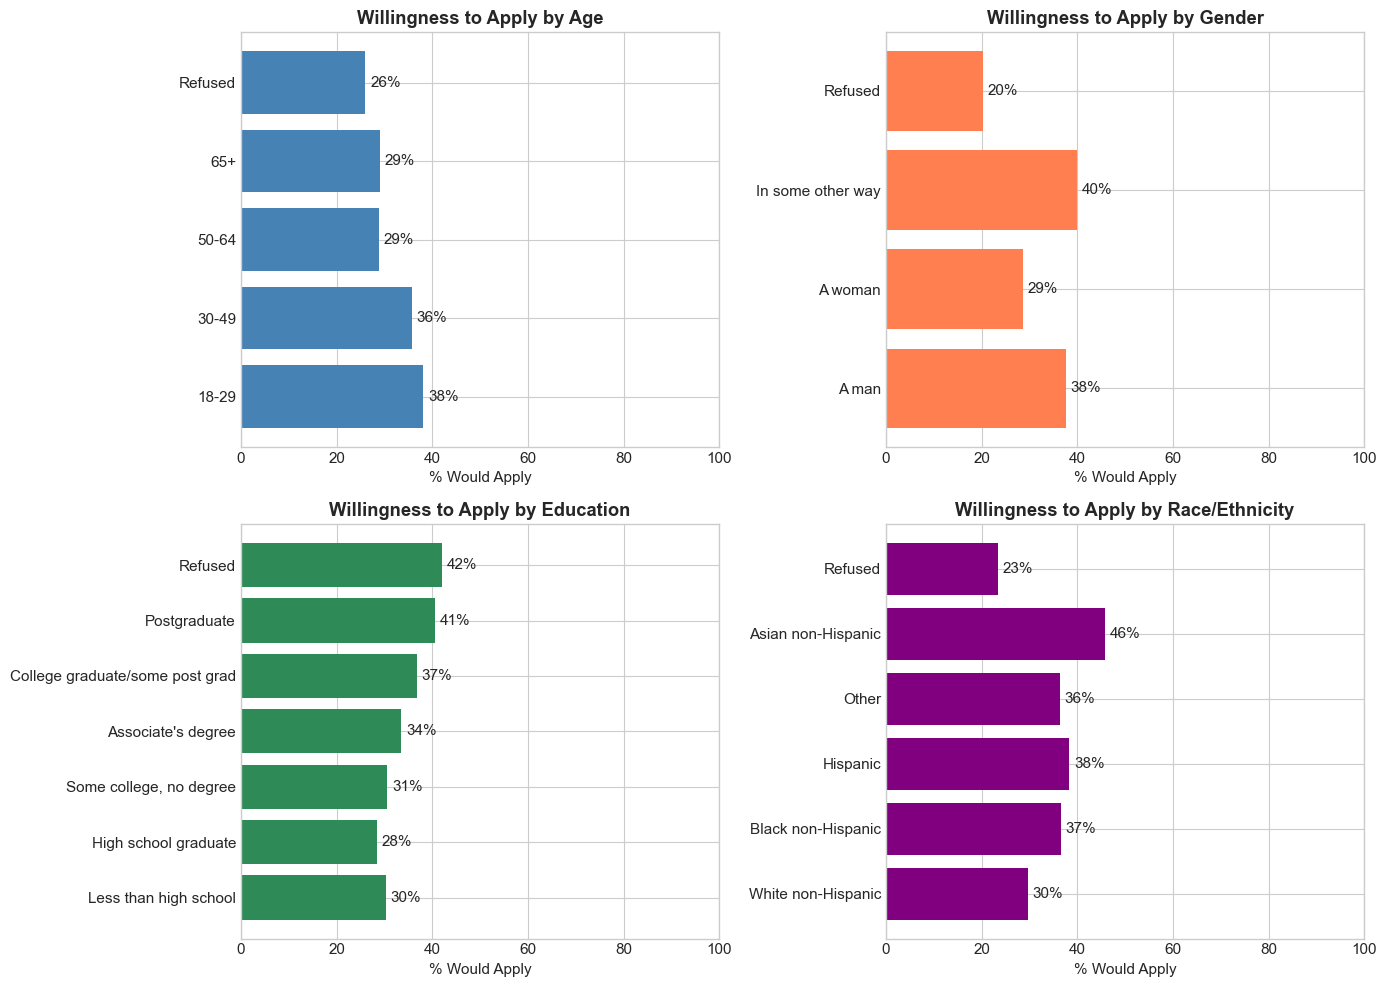

In [10]:
# Visualize demographic differences
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age
if 'F_AGECAT' in demo_results:
    data = demo_results['F_AGECAT']
    axes[0, 0].barh(data['group_label'], data['pct_would_apply'], color='steelblue')
    axes[0, 0].set_xlabel('% Would Apply')
    axes[0, 0].set_title('Willingness to Apply by Age', fontweight='bold')
    axes[0, 0].set_xlim(0, 100)
    for i, v in enumerate(data['pct_would_apply']):
        axes[0, 0].text(v + 1, i, f'{v:.0f}%', va='center')

# Gender
if 'F_GENDER' in demo_results:
    data = demo_results['F_GENDER']
    axes[0, 1].barh(data['group_label'], data['pct_would_apply'], color='coral')
    axes[0, 1].set_xlabel('% Would Apply')
    axes[0, 1].set_title('Willingness to Apply by Gender', fontweight='bold')
    axes[0, 1].set_xlim(0, 100)
    for i, v in enumerate(data['pct_would_apply']):
        axes[0, 1].text(v + 1, i, f'{v:.0f}%', va='center')

# Education
if 'F_EDUCCAT2' in demo_results:
    data = demo_results['F_EDUCCAT2']
    axes[1, 0].barh(data['group_label'], data['pct_would_apply'], color='seagreen')
    axes[1, 0].set_xlabel('% Would Apply')
    axes[1, 0].set_title('Willingness to Apply by Education', fontweight='bold')
    axes[1, 0].set_xlim(0, 100)
    for i, v in enumerate(data['pct_would_apply']):
        axes[1, 0].text(v + 1, i, f'{v:.0f}%', va='center')

# Race/Ethnicity
if 'F_RACETHNMOD' in demo_results:
    data = demo_results['F_RACETHNMOD']
    axes[1, 1].barh(data['group_label'], data['pct_would_apply'], color='purple')
    axes[1, 1].set_xlabel('% Would Apply')
    axes[1, 1].set_title('Willingness to Apply by Race/Ethnicity', fontweight='bold')
    axes[1, 1].set_xlim(0, 100)
    for i, v in enumerate(data['pct_would_apply']):
        axes[1, 1].text(v + 1, i, f'{v:.0f}%', va='center')

plt.tight_layout()
plt.savefig('../reports/demographic_splits.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Bivariate Associations with Primary Outcome

Examine relationships between potential predictors and willingness to apply.

WILLINGNESS TO APPLY BY AI KNOWLEDGE INDEX (0-6)
 group_code group_label  n_unweighted  pct_would_apply
        0.0         0.0          1184             20.1
        1.0         1.0           785             32.0
        2.0         2.0           910             30.8
        3.0         3.0          1079             30.9
        4.0         4.0          1399             31.9
        5.0         5.0          1873             36.2
        6.0         6.0          3541             38.9


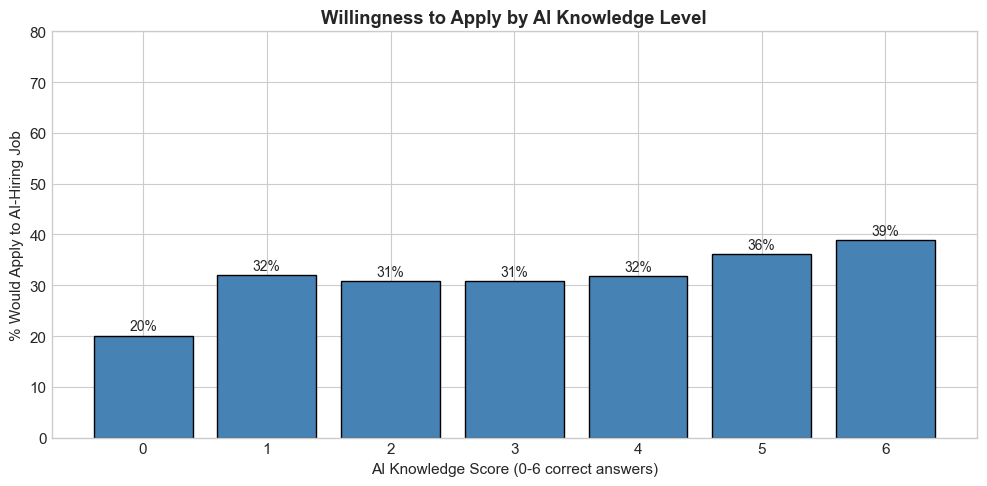

In [11]:
# AI Knowledge Index vs Willingness to Apply
if 'AIKNOW_INDEX_W119' in df.columns:
    print("WILLINGNESS TO APPLY BY AI KNOWLEDGE INDEX (0-6)")
    print("="*60)
    knowledge_results = weighted_mean_by_group(df, 'AIWRKH4_BINARY', 'AIKNOW_INDEX_W119')
    print(knowledge_results.to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(knowledge_results['group_code'], knowledge_results['pct_would_apply'], color='steelblue', edgecolor='black')
    ax.set_xlabel('AI Knowledge Score (0-6 correct answers)')
    ax.set_ylabel('% Would Apply to AI-Hiring Job')
    ax.set_title('Willingness to Apply by AI Knowledge Level', fontweight='bold')
    ax.set_xticks(range(7))
    
    for i, v in enumerate(knowledge_results['pct_would_apply']):
        ax.text(i, v + 1, f'{v:.0f}%', ha='center', fontsize=10)
    
    ax.set_ylim(0, 80)
    plt.tight_layout()
    plt.savefig('../reports/knowledge_vs_willingness.png', dpi=150, bbox_inches='tight')
    plt.show()

In [12]:
# Cross-tabulate: Awareness of AI hiring vs Willingness to apply
if 'AIWRKH1_W119' in df.columns:
    print("\nWILLINGNESS TO APPLY BY AWARENESS OF AI IN HIRING")
    print("="*60)
    awareness_results = weighted_mean_by_group(df, 'AIWRKH4_BINARY', 'AIWRKH1_W119')
    print(awareness_results.to_string(index=False))

# Cross-tabulate: Opinion on AI bias vs Willingness to apply
if 'HIREBIAS1_W119' in df.columns:
    print("\nWILLINGNESS TO APPLY BY OPINION ON AI BIAS")
    print("="*60)
    bias_results = weighted_mean_by_group(df, 'AIWRKH4_BINARY', 'HIREBIAS1_W119')
    print(bias_results.to_string(index=False))

# Cross-tabulate: Perceived impact on self vs Willingness to apply
if 'HIREBIAS2_W119' in df.columns:
    print("\nWILLINGNESS TO APPLY BY PERCEIVED PERSONAL IMPACT")
    print("="*60)
    impact_results = weighted_mean_by_group(df, 'AIWRKH4_BINARY', 'HIREBIAS2_W119')
    print(impact_results.to_string(index=False))


WILLINGNESS TO APPLY BY AWARENESS OF AI IN HIRING
 group_code    group_label  n_unweighted  pct_would_apply
        1.0          A lot           810             48.2
        2.0       A little          3652             41.3
        3.0 Nothing at all          6290             26.7
       99.0        Refused            19             51.4

WILLINGNESS TO APPLY BY OPINION ON AI BIAS
 group_code     group_label  n_unweighted  pct_would_apply
        1.0 A major problem          4216             38.9
        2.0 A minor problem          4573             33.3
        3.0   Not a problem          1838             21.6
       99.0         Refused           144             20.6

WILLINGNESS TO APPLY BY PERCEIVED PERSONAL IMPACT
 group_code           group_label  n_unweighted  pct_would_apply
        1.0 Definitely get better           829             64.2
        2.0   Probably get better          3960             46.2
        3.0   Stay about the same          2870             21.4
        4

## 5. Correlation Analysis

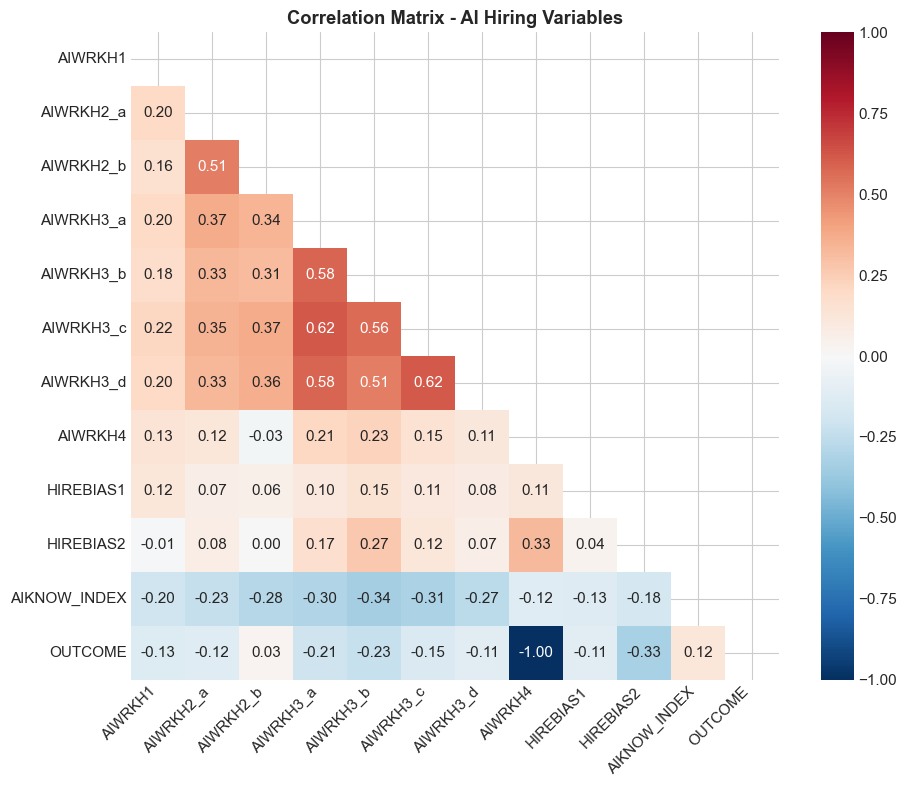

In [13]:
# Correlation matrix for hiring variables
hiring_vars_in_data = [v for v in HIRING_VARS if v in df.columns]
corr_vars = hiring_vars_in_data + ['AIKNOW_INDEX_W119', 'AIWRKH4_BINARY']
corr_vars = [v for v in corr_vars if v in df.columns]

# Create correlation matrix (unweighted for simplicity)
corr_df = df[corr_vars].copy()
# Replace 99 with NaN for correlation
for col in corr_df.columns:
    corr_df[col] = corr_df[col].replace(99, np.nan)

corr_matrix = corr_df.corr()

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, ax=ax, square=True)
ax.set_title('Correlation Matrix - AI Hiring Variables', fontweight='bold')

# Simplify labels
labels = [v.replace('_W119', '').replace('AIWRKH4_BINARY', 'OUTCOME') for v in corr_vars]
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticklabels(labels, rotation=0)

plt.tight_layout()
plt.savefig('../reports/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Key EDA Findings Summary

### Headline Statistics:
- **Primary Outcome (AIWRKH4)**: Willingness to apply to a job using AI in hiring
- Approximately **X%** would definitely/probably apply vs **Y%** would probably/definitely not

### Demographic Patterns:
1. **Age**: Younger adults more likely to apply
2. **Education**: Higher education associated with higher willingness
3. **Race/Ethnicity**: Variation across groups

### Predictor Relationships:
1. **AI Knowledge Index**: Positive relationship - higher knowledge = more willing
2. **Awareness (AIWRKH1)**: Those aware of AI hiring are [more/less] willing
3. **Bias perception (HIREBIAS1)**: Strong predictor of willingness
4. **Personal impact (HIREBIAS2)**: Those who think AI would help them are more willing

### Next Steps for Modeling:
- Use AIWRKH4_BINARY as outcome
- Include AI knowledge, bias perceptions, demographics as predictors
- Account for survey weights in model fitting